# Tutorial - Step2 : MTMR finetuning with Reinforcement learning

## 1. Import requirements

In [1]:
import os
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [2]:
from MTMR.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from MTMR.vae import SmilesAutoencoder, RewardFunction
from MTMR.properties import drd2, qed, similarity

## 2. Configure GPU (if available)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [4]:
PROPERTY_NAME = "qed"

SCORING_PROPERTY_FT = qed
SCORING_TANIMOTO_FT = similarity

## Configure the parameters of a reward function for the target property
threshold_property = 0.75
threshold_similarity = 0.3

## 4. Set directories (for inputs and outputs)¶

In [5]:
input_data_dir = os.path.join("DATA", PROPERTY_NAME)
input_ckpt_dir = os.path.join("outputs_Tutorial_1_MTMR_pretraining", PROPERTY_NAME)

In [6]:
_output_dir = "outputs_Tutorial_2_MTMR_finetuning-Copy1"
if not os.path.exists(_output_dir):
    os.mkdir(_output_dir)

output_dir = os.path.join(_output_dir, PROPERTY_NAME)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set file names

In [7]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_data_dir, "rdkit_valid.txt")

In [8]:
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

In [9]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)
dataset.save_char2idx(filepath_char2idx)
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load a pretrained generator of MTMR

In [11]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [12]:
reward_ft = RewardFunction(similarity_ft=SCORING_TANIMOTO_FT,
                           scoring_ft=SCORING_PROPERTY_FT,
                           threshold_property=threshold_property,
                           threshold_similarity=threshold_similarity)

## 9. Train

In [13]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft,
                                                         validation_dataset=dataset_valid,
                                                         checkpoint_filepath=filepath_checkpoint,
                                                         use_adaptive_threshold=True)

df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

[000000/002000]  loss: 0.021  reward: 0.264  similarity: 0.619  property[0]: 0.816  valid_ratio(va): 1.000  similarity(va): 0.370  property(va): 0.753
[000010/002000]  loss: 0.022  reward: 0.276  similarity: 0.627  property[0]: 0.821  valid_ratio(va): 0.992  similarity(va): 0.373  property(va): 0.768
[000020/002000]  loss: 0.022  reward: 0.276  similarity: 0.595  property[0]: 0.832  valid_ratio(va): 0.992  similarity(va): 0.373  property(va): 0.779
[000030/002000]  loss: 0.023  reward: 0.328  similarity: 0.570  property[0]: 0.851  valid_ratio(va): 0.997  similarity(va): 0.374  property(va): 0.790
[000040/002000]  loss: 0.024  reward: 0.376  similarity: 0.530  property[0]: 0.869  valid_ratio(va): 1.000  similarity(va): 0.371  property(va): 0.794
[000050/002000]  loss: 0.026  reward: 0.371  similarity: 0.519  property[0]: 0.871  valid_ratio(va): 1.000  similarity(va): 0.369  property(va): 0.803
[000060/002000]  loss: 0.022  reward: 0.371  similarity: 0.515  property[0]: 0.876  valid_rati

[000550/002000]  loss: 0.016  reward: 0.342  similarity: 0.467  property[0]: 0.905  valid_ratio(va): 1.000  similarity(va): 0.324  property(va): 0.860
[000560/002000]  loss: 0.018  reward: 0.335  similarity: 0.458  property[0]: 0.907  valid_ratio(va): 1.000  similarity(va): 0.325  property(va): 0.858
[000570/002000]  loss: 0.020  reward: 0.342  similarity: 0.447  property[0]: 0.907  valid_ratio(va): 0.997  similarity(va): 0.324  property(va): 0.857
[000580/002000]  loss: 0.020  reward: 0.333  similarity: 0.453  property[0]: 0.904  valid_ratio(va): 1.000  similarity(va): 0.325  property(va): 0.860
[000590/002000]  loss: 0.020  reward: 0.319  similarity: 0.469  property[0]: 0.905  valid_ratio(va): 0.997  similarity(va): 0.321  property(va): 0.858
[000600/002000]  loss: 0.019  reward: 0.359  similarity: 0.468  property[0]: 0.909  valid_ratio(va): 0.997  similarity(va): 0.320  property(va): 0.861
[000610/002000]  loss: 0.018  reward: 0.325  similarity: 0.452  property[0]: 0.906  valid_rati

[001100/002000]  loss: 0.016  reward: 0.323  similarity: 0.449  property[0]: 0.916  valid_ratio(va): 1.000  similarity(va): 0.310  property(va): 0.877
[001110/002000]  loss: 0.015  reward: 0.323  similarity: 0.456  property[0]: 0.917  valid_ratio(va): 1.000  similarity(va): 0.309  property(va): 0.878
[001120/002000]  loss: 0.016  reward: 0.315  similarity: 0.429  property[0]: 0.916  valid_ratio(va): 1.000  similarity(va): 0.309  property(va): 0.879
[001130/002000]  loss: 0.018  reward: 0.316  similarity: 0.430  property[0]: 0.917  valid_ratio(va): 1.000  similarity(va): 0.308  property(va): 0.876
[001140/002000]  loss: 0.015  reward: 0.301  similarity: 0.453  property[0]: 0.914  valid_ratio(va): 1.000  similarity(va): 0.311  property(va): 0.877
[001150/002000]  loss: 0.015  reward: 0.303  similarity: 0.458  property[0]: 0.914  valid_ratio(va): 1.000  similarity(va): 0.309  property(va): 0.877
[001160/002000]  loss: 0.016  reward: 0.317  similarity: 0.459  property[0]: 0.916  valid_rati

[001650/002000]  loss: 0.015  reward: 0.325  similarity: 0.444  property[0]: 0.922  valid_ratio(va): 1.000  similarity(va): 0.299  property(va): 0.887
[001660/002000]  loss: 0.014  reward: 0.310  similarity: 0.429  property[0]: 0.922  valid_ratio(va): 1.000  similarity(va): 0.296  property(va): 0.886
[001670/002000]  loss: 0.015  reward: 0.315  similarity: 0.423  property[0]: 0.922  valid_ratio(va): 1.000  similarity(va): 0.297  property(va): 0.887
[001680/002000]  loss: 0.014  reward: 0.307  similarity: 0.459  property[0]: 0.922  valid_ratio(va): 1.000  similarity(va): 0.298  property(va): 0.887
[001690/002000]  loss: 0.015  reward: 0.288  similarity: 0.428  property[0]: 0.920  valid_ratio(va): 0.997  similarity(va): 0.293  property(va): 0.887
[001700/002000]  loss: 0.015  reward: 0.309  similarity: 0.432  property[0]: 0.922  valid_ratio(va): 1.000  similarity(va): 0.296  property(va): 0.889
[001710/002000]  loss: 0.016  reward: 0.306  similarity: 0.428  property[0]: 0.923  valid_rati

NameError: name 'history' is not defined

In [14]:
df_history = pd.DataFrame(generator.history, columns=["LOSS", "REWARD", "SIMILARITY", "PROPERTY"])
df_history_valid = pd.concat(generator.history_valid)

## 10. Visualize for reward & loss analysis

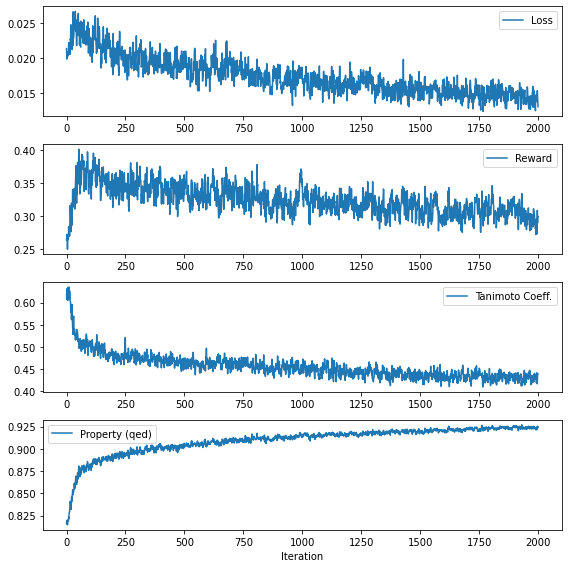

In [15]:
fig, axes = plt.subplots(4,1,figsize=(8,8))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

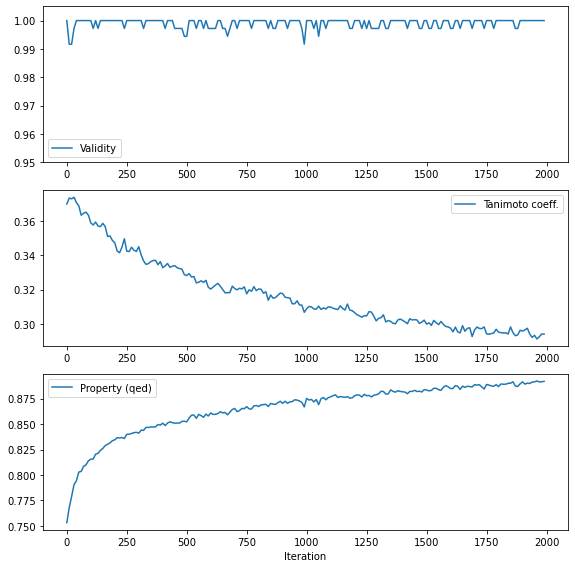

In [17]:
fig, axes = plt.subplots(3,1,figsize=(8,8))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()